In [1]:

#alguns imports

import sys
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster

from IPython.display import display

import warnings

warnings.filterwarnings("ignore")


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1653691443703_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#criar uma instância SparkSession

spark = SparkSession\
    .builder\
    .appName("Dataset")\
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagerEval.enabled", True)\
    .getOrCreate()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Leitura do ficheiro que contém os dados relativos ao ano 2021
df_raw = spark.read.csv("s3://bigdatanoaa/Dataset/2015.csv",header="false",inferSchema="true",sep=",")

#Renomeação das colunas
df_raw = df_raw.toDF("ID", "DATE", "ELEMENT", "DATA VALUE", "MFLAG", "QFLAG","SFLAG", "OBS_TIME")

#Leitura dos dados relativos aos países
df_countries = spark.read.csv("s3://bigdatanoaa/ghcnd-countries.csv",header="false",inferSchema="true",sep=";")

#Renomeação das colunas
df_countries = df_countries.toDF("CODIGO", "PAIS", "CONTINENTE")

#Leitura dos dados relativos às estações
df_stations = spark.read.csv("s3://bigdatanoaa/ghcnd-stations.csv", header="false",inferSchema="true", sep=";")

#Renomeação das colunas
df_stations = df_stations.toDF("ID_STATION", "LATITUDE", "LONGITUDE","ELEVAÇÃO", "ESTADO", "NOME", "GSM_FLAG", "HCN-CRM_FLAG", "WMO ID")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:

#colunas irrelevantes
cols_to_drop = ['MFLAG', 'QFLAG', 'SFLAG', 'OBS_TIME']
cols_to_drop2 = ['ELEVAÇÃO', 'ESTADO', 'GSM_FLAG', 'HCN-CRM_FLAG', 'WMO ID']

#colunas de interesse
cols_interest = [x for x in df_raw.columns if x not in cols_to_drop]
cols_interest2 = [x for x in df_stations.columns if x not in cols_to_drop2]

#eliminação das colunas irrelevantes
df_raw_interest = df_raw.select(cols_interest)
df_stations_interest = df_stations.select(cols_interest2)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:

# Os valores correspondentes às temperaturas e preciciptação apresentam inicialmente um formato de tenth of degrees
# É preciso dividir esses valores por 10 de modo a obter o valor em graus centígrados

df_raw_interest = df_raw_interest.withColumn("DATA VALUE",
    when((col("ELEMENT") == "TMAX") | (col("ELEMENT") == "TMIN") |
         (col("ELEMENT") == "TAVG") | (col("ELEMENT") == "PRCP"),
         round((col("DATA VALUE") / 10), 2)).otherwise(col("DATA VALUE")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:

#Adicionar o nome dos países de modo a associarmos o id da estação meteorológica ao seu respetivo país
new_data = (df_raw_interest.join(df_stations_interest).where(
    df_raw_interest["ID"] == df_stations["ID_STATION"]).drop("ID_STATION"))

#Adicionar o nome dos países de modo a associarmos o id da estação meteorológica ao seu respetivo país
all_data = new_data.join(df_countries).where(
    col("ID").substr(1, 2) == df_countries["CODIGO"]).drop("CODIGO")

#Passagem das datas para forma de data de modo a conseguirmos comparar as datas
all_data = all_data.withColumn("DATE", to_date(col("DATE").cast(StringType()), "yyyyMMdd"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:

#Filtragem de modo a obter os dados relativos à temperatura média
df_avg = all_data.filter(col("ELEMENT") == "TAVG")

#Renomeação do nome da coluna para não existir qualquer tipo de conflito
df_avg = df_avg.withColumnRenamed("DATA VALUE", "TAVG").drop("ELEMENT")

#Agrupação de dados conforme o nome da estação, o país onde se encontra e o mês de observação
#É feita a média das temperaturas médias e ordenado comforme o mês
mean_data = (df_avg.groupBy(['NOME', 'PAIS', month(col("DATE"))]).avg("TAVG").orderBy(month(col("DATE"))))

#Passagem da variável mês para o tipo de String
mean_data = mean_data.withColumn("month(DATE)",col("month(DATE)").cast(StringType()))

#Criação de 12 novas colunas, sendo que cada uma vai conter o valor médio de temperatura do mês respetivo
mean_data = mean_data.groupBy("NOME").pivot("month(DATE)").avg("avg(TAVG)")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:

#Criada uma variável que contenha o nome das estações, os seus países, a sua latitude e longitude
cities_data = df_avg[['NOME', 'PAIS', 'LATITUDE', 'LONGITUDE']]
#Renomear as colunas
cities_data = cities_data.toDF("NAME", "COUNTRY", "LATITUDE", "LONGITUDE")

#É feita a agrupação de dados, de modo a obtermos a latitude e longitude para as estações pretendidas
join_data = mean_data.join(cities_data).where(
    col("NOME") == cities_data["NAME"]).drop("NAME")

#Eliminação de estações que se possam encontrar duplicadas
unique_data = join_data.select("*").dropDuplicates(["NOME"])

#Renomear as colunas de modo a conseguirmos realizar uma ordenação das mesmas
unique_data = unique_data.toDF("NOME", "01", "10", "11", "12", "02", "03", "04", "05", "06", "07", "08", "09", "PAÍS", "LATITUDE","LONGITUDE")
#Ordenação das colunas
unique_data = unique_data.select(sorted(unique_data.columns))
#Renomear novamente as colunas para o formato pretendido
unique_data = unique_data.toDF("1", "2", "3", "4", "5", "6", "7", "8", "9","10", "11", "12", "LATITUDE", "LONGITUDE","NOME", "PAIS")

#Filtragem de forma a obtermos os dados relativos às estações que se localizam no hemisfério norte,
#ou seja, quando o valor da latitude é maior que 0
north_stations = unique_data.filter(col("LATITUDE") > 0)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:

#Quando uma linha contém pelo menos um valor null, a mesma será elimnada
df_clean = north_stations.dropna()

#Comparação de tamanho entre o dataframe que contém os valores nulos e o dataframe que não contém
#isto é feito de modo a saber se podemos prosseguir
[north_stations.count(), df_clean.count()]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[6402, 4951]

In [10]:

#As colunas que dizem respeito a strings são desprezadas, pois não faz sentido criarmos features com as mesmas
columns = [col for col in df_clean.columns if col not in ['NOME', 'PAIS', 'LATITUDE', 'LONGITUDE']]

#Criação de um vetor que recebe como entrada as colunas pretendidas, criando uma coluna de vetores de features
assembler = VectorAssembler(inputCols=columns, outputCol="features_clustering")

#O vetor é associado aos nossos dados
train_clustering = assembler.transform(df_clean)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:

#Criação de um classificador de clustering, de modo a obtermos os valores de erro
evaluator = ClusteringEvaluator(featuresCol='features_clustering',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:

#Será feito um ciclo que tem como objetivo, através da variação do número de clusters, verificar qual o
#número de clusters ideal para a construção do nosso modelo

k_tests = 20
cost = np.zeros(k_tests)
for K in range(2, k_tests):
    kmeans = KMeans(featuresCol='features_clustering', k=K)

    model_k = kmeans.fit(train_clustering)
    output = model_k.transform(train_clustering)
    cost[K] = evaluator.evaluate(output)
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-12:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2472



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

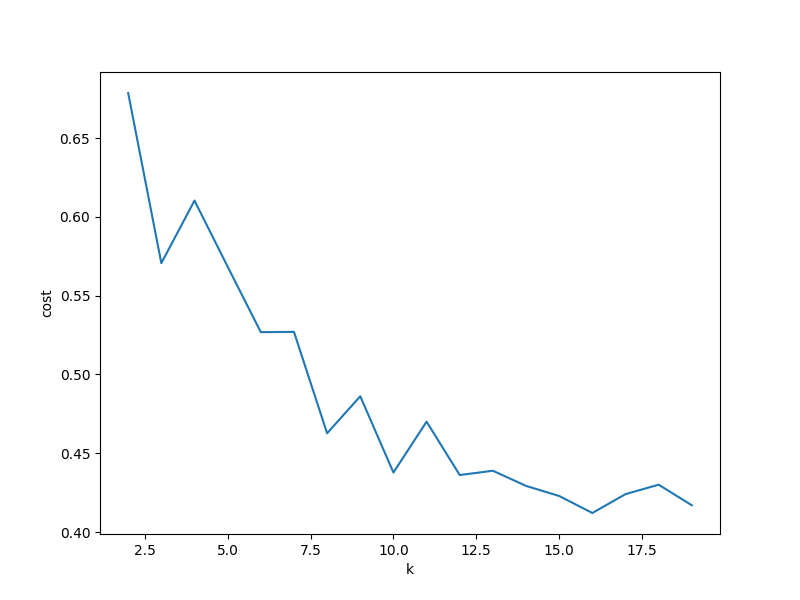

In [13]:

#São feitos os imports novamente de modo a permitir a visualização do gráfico
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Construção do gráfico em que temos o valor de erro consoante o número de clusters utilizado
#Decidimos usar 12 clusters, pois acreditamos que seja um bom valor
fig, ax = plt.subplots(1,1,figsize=(8, 6),)
ax.plot(range(2, k_tests), cost[2:k_tests])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

#Comando local para permitir a visualização do gráfico
%matplot plt


In [14]:

#Construção de um modelo de clustering, usando 12 clusters
kmeans_real = KMeans(featuresCol='features_clustering', k=12)

#Configuração de modo a que o modelo seja treinado
model_real = kmeans_real.fit(train_clustering)

#Para cada estação meteorológica, é feita uma previsão do cluster a que pertence
#É, também, criada uma nova coluna com os valores previstos
predict = model_real.transform(train_clustering)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-14:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 4755



In [17]:

#Os dados obtidos vão ser guardados, em formato parquet, no bucket criado pelo nosso grupo
#Como não é possível visualizar o nosso mapa na platafomra aws, estes dados são guardados para serem vistos de forma local
#predict.write.format('parquet').save('s3://bigdatanoaa/world_map')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:

#Este código permite criar um mapa do mundo, ao qual vão ser adicionados os diversos clusters criados pelo nosso modelo
#Através do mapa, conseguimos observar todas as estações do hemisfério norte, coloridas conforme o cluster previsto
#Visto que a visualização do mapa não é possível, este código vai ser implementado num outro notebook processado de forma local

#import folium
#from IPython.display import display

#world_map = folium.Map()
#geolocator = Nominatim(user_agent="Temperatures")

#city_color = [
    #"red",
    #"yellow",
    #"blue",
    #"yellow",
    #"violet",
    #"purple",
    #"pink",
    #"silver",
    #"gold",
    #"green",
    #"brown",
    #"black",
    #"gray",
#]

#collect_data = predict.collect()

#for raw in collect_data:

    #lat = raw["LATITUDE"]
    #long = raw["LONGITUDE"]

    #folium.Circle(location=[lat, long],
                  #popup=raw["NOME"],
                  #radius=30000,
                  #color=city_color[raw["prediction"]],
                  #fill=True,
                  #fill_color=city_color[raw["prediction"]]).add_to(world_map)

#display(world_map)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…